# # RRT* 설치
---

In [ ]:
!git clone https://github.com/Bharath2/Informed-RRT-star
%cd /content/Informed-RRT-star
# %pip install -qr requirements.txt
!pip install rtree
!pip install pymysql
!pip install pyproj
!pip install geopandas
!pip install pyshp

Cloning into 'Informed-RRT-star'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 96 (delta 36), reused 53 (delta 17), pack-reused 0
Unpacking objects: 100% (96/96), done.
/content/Informed-RRT-star
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 16.7 MB 61.7 MB/s 
Looking in indexe

In [ ]:
# 모듈 경로 추가하는 법

import sys
sys.path.append("/content/Informed-RRT-star")

In [ ]:
import numpy as np
import re
import pymysql
import pandas as pd
import geopandas as gpd
from PathPlanning import RRT, RRTStar, Map
import matplotlib.pyplot as plt

# # informed RRT* 실제 좌표에 적용
---

## # 데이터 불러오기
---

### # 빌딩
---

In [ ]:
conn = pymysql.connect(host='34.64.132.212', user='root', password='ASewetsvc124~1242#%1wsdeWXV', db='source')
sql_state='SELECT * FROM `building_100(25)`'
building=pd.read_sql_query(sql_state, conn)

building

,BLD_NM,GRND_FLR,HEIGHT,height2,geometry
0,롯데캐슬 천지인,30.0,93.60,105.0,POLYGON ((127.01607842981515 37.57386084062459...
1,흥국생명빌딩,24.0,122.50,84.0,POLYGON ((126.97247318240198 37.56961584628065...
2,레이크팰리스,30.0,83.20,105.0,POLYGON ((127.09695586041401 37.50945025073049...
3,None,5.0,193.50,17.5,POLYGON ((126.98458195236762 37.57845365662985...
4,31빌딩,31.0,110.82,108.5,POLYGON ((126.98737859751343 37.56871648497102...
...,...,...,...,...,...
882,잠실 더샵스타파크,39.0,127.56,136.5,"POLYGON ((127.10242070457794 37.5174021295307,..."
883,천호역 한강 푸르지오시티,35.0,111.05,122.5,POLYGON ((127.12569750417126 37.54071980893323...
884,서울파이낸스센터,30.0,124.43,105.0,POLYGON ((126.97890114948189 37.56827558378212...
885,아이파크 포레스트 게이트,27.0,94.44,94.5,POLYGON ((126.91862960311435 37.63295710745815...


### # 산
---

In [ ]:
mountain = gpd.read_file('/content/drive/MyDrive/중앙정보처리학원/5조 팀프로젝트.lnk/3차 프로젝트/자료/산림지도/11.shp', encoding='euc-kr')
mountain=mountain[['geometry']]
mountain=mountain.to_crs(epsg=4326)
mountain['geometry']=mountain['geometry'].astype('str')
mountain=mountain.drop(697)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


### # 범위 지정 데이터 (임시)
---

In [ ]:
building = pd.read_csv('/content/drive/MyDrive/중앙정보처리학원/5조 팀프로젝트.lnk/3차 프로젝트/지도 웹 구현/building_index.csv')
building = building.loc[building['within'] == True]
building['geometry'] = gpd.GeoSeries.from_wkt(building['geometry'])
building.head()

,BLD_NM,GRND_FLR,HEIGHT,height2,geometry,within
0,종암에스케이아파트,27.0,73.0,94.5,"POLYGON ((127.03588 37.60164, 127.03602 37.601...",True
1,종암에스케이아파트,27.0,73.0,94.5,"POLYGON ((127.03680 37.60091, 127.03693 37.600...",True
2,종암에스케이아파트,27.0,73.0,94.5,"POLYGON ((127.03605 37.60166, 127.03593 37.601...",True
3,종암에스케이아파트,27.0,73.0,94.5,"POLYGON ((127.03798 37.60111, 127.03800 37.601...",True
4,종암에스케이아파트,27.0,73.0,94.5,"POLYGON ((127.03688 37.60101, 127.03696 37.601...",True


In [ ]:
mountain = pd.read_csv('/content/drive/MyDrive/중앙정보처리학원/5조 팀프로젝트.lnk/3차 프로젝트/지도 웹 구현/mountain_index.csv')
mountain.head()

,geometry,within
0,"POLYGON ((127.0594213159223 37.60491761806035,...",True
1,POLYGON ((127.06020156575886 37.60371193344382...,True
2,"POLYGON ((127.0494489809654 37.63071773703272,...",True
3,POLYGON ((127.04730991717213 37.61028656874326...,True
4,POLYGON ((127.0458733697772 37.610704636195166...,True


## # 장애물 설정 (다각형 형태로 바꾸기)
---


In [ ]:
# start, goal
# start = [127.10591473875319, 37.50607824298996]
# goal = [127.10823825113607, 37.526563966361216]
# start = [127.0721206665039, 37.54084396362305]
# goal = [127.0979995727539, 37.50274658203125]
# start = [126.923,37.6007]
# goal = [126.946,37.5889]
start = [127.06188270282503, 37.647144401815204]
goal = [127.03114819168812, 37.584783604541]

start_grid = start
goal_grid = goal

# obstacles = np.array(df_gpd.grid)
# obstacles = []
# for obs in building['geometry'].values:
#     obs = re.sub('POLYGON \(\(', '', obs)
#     obs = re.sub(',', '', obs)
#     obs = re.sub('\)', '', obs).split(' ')
#     obs = list(map(float, obs))

#     for i in range(int(len(obs)/2)):
#         if 4+i*2 <= len(obs):
#             obstacles.append(obs[0+i*2 : 4+i*2])

obstacles = []
for buil_obs in building['geometry']:
    obstacles.append(list(buil_obs.bounds))

for obs_ in mountain.geometry.values:
    for obs in obs_.split('), ('):
        obs = re.sub('POLYGON ', '', obs)
        obs = re.sub(',', '', obs)
        obs = re.sub('\(', '', obs)
        obs = re.sub('\)', '', obs).split(' ')
        obs = list(map(float, obs))

        for i in range(int(len(obs)/2)):
            if 202+i*2<= len(obs):
                obstacles.append(obs[0+i*2 : 2+i*2] + obs[10+i*2 : 12+i*2])

for i in obstacles:
  for j in range(len(i)):
    if j % 2 == 0:
      i[j] -= start_grid[0] 
      i[j] *= 10000
    if j % 2 == 1:
      i[j] -= start_grid[1]
      i[j] *= 10000

goal_grid[0] -= start_grid[0] 
goal_grid[0] *= 10000
goal_grid[1] -= start_grid[1] 
goal_grid[1] *= 10000
start_grid_new = tuple([0,0])
goal_grid = tuple(goal_grid)

### # 건물 사각형, 산 안쪽 채우기
---

In [ ]:
# start, goal
# start = [127.10591473875319, 37.50607824298996]
# goal = [127.10823825113607, 37.526563966361216]
# start = [127.0721206665039, 37.54084396362305]
# goal = [127.0979995727539, 37.50274658203125]
# start = [126.923,37.6007]
# goal = [126.946,37.5889]
start = [127.06188270282503, 37.647144401815204]
goal = [127.03114819168812, 37.584783604541]

start_grid = start
goal_grid = goal

# obstacles = np.array(df_gpd.grid)

obstacles = []
for buil_obs in building['geometry']:
    obstacles.append(list(buil_obs.bounds))

for obs_ in mountain['geometry']:
    for obs in obs_.split('), ('):
        obs = re.sub('POLYGON ', '', obs)
        obs = re.sub(',', '', obs)
        obs = re.sub('\(', '', obs)
        obs = re.sub('\)', '', obs).split(' ')
        obs = list(map(float, obs))

        for i in range(int(len(obs)/2)):
            if (len(obs)/2) % 2 == 0:
                if int(len(obs)/2) + 2 +i*2 <= len(obs):
                    obstacles.append(obs[0+i*2 : 2+i*2] + obs[int(len(obs)/2) + i*2 : int(len(obs)/2)+2 +i*2])
            elif (len(obs)/2) % 2 == 1:
                if int(len(obs)/2) + 2 +i*2 <= len(obs):
                    obstacles.append(obs[0+i*2 : 2+i*2] + obs[int(len(obs)/2)+1 + i*2 : int(len(obs)/2)+3 +i*2])


for i in obstacles:
  for j in range(len(i)):
    if j % 2 == 0:
      i[j] -= start_grid[0] 
      i[j] *= 10000
    if j % 2 == 1:
      i[j] -= start_grid[1]
      i[j] *= 10000

goal_grid[0] -= start_grid[0] 
goal_grid[0] *= 10000
goal_grid[1] -= start_grid[1] 
goal_grid[1] *= 10000
start_grid_new = tuple([0,0])
goal_grid = tuple(goal_grid)

In [ ]:
len(obstacles)

12227

In [ ]:
for i in obstacles:
    if len(i) < 4:
        print(i)

## # 경계선
---

In [ ]:
rest_api_key = 'e535b07f417c6dc974507ee3d8c0f9fc'

start = '127.06188270282503, 37.647144401815204'
goal = '127.03114819168812, 37.584783604541'

def boundary(rest_api_key, start, goal, priority = 'RECOMMEND'):
    import json
    import requests
    
    headers = {"Authorization": f"KakaoAK {rest_api_key}"}
    url = f"https://apis-navi.kakaomobility.com/v1/directions?origin={start}&destination={goal}&waypoints=&priority={priority}&car_fuel=GASOLINE&car_hipass=false&alternatives=false&road_details=false"
    
    res = requests.get(url, headers=headers)
    document = json.loads(res.text)
    boundary = list(document['routes'][0]['summary']['bound'].values())

    return boundary

boundary = boundary(rest_api_key, start, goal)
boundary

[127.03070959393301, 37.584665486563026, 127.06183189579312, 37.64710672317207]

In [ ]:
# # 장애물 형태로 경계선 넣어주기
# x = goal_grid[0]
# y = goal_grid[1]
# f = 100

# if x < 0 and y < 0: 
#   upper = [goal_grid[0]-(f+100),f,f,(f+100)]
#   right = [f,(f+100),(f+100),goal_grid[1]-f]
#   lower = [(f+100),goal_grid[1]-f,goal_grid[0]-f,goal_grid[1]-(f+100)]
#   left = [goal_grid[0]-f,goal_grid[1]-(f+100),goal_grid[0]-(f+100),f]
# elif x < 0 and y > 0:
#   upper = [goal_grid[0]-(f+100),goal_grid[1]+f,f,goal_grid[1]+(f+100)]
#   right = [f,goal_grid[1]+(f+100),(f+100), -f]
#   lower = [(f+100), -f,goal_grid[0]-f,-(f+100)]
#   left = [goal_grid[0]-f,-(f+100),goal_grid[0]-(f+100),goal_grid[1]+f]
# elif x > 0 and y < 0:
#   upper = [-(f+100),f,goal_grid[0]+f,(f+100)]
#   right = [goal_grid[0]+f,(f+100),goal_grid[0]+(f+100),goal_grid[1]-f]
#   lower = [goal_grid[0]+f,goal_grid[1]-f,-f,goal_grid[1]-(f+100)]
#   left = [-f,goal_grid[1]-(f+100),-(f+100),f]
# else:
#   upper = [-(f+100),goal_grid[1]+f,goal_grid[0]+f,goal_grid[1]+(f+100)]
#   right = [goal_grid[0]+f,goal_grid[1]+(f+100),goal_grid[0]+(f+100),-f]
#   lower = [goal_grid[0]+(f+100),-f,-f,-(f+100)]
#   left = [-f,-(f+100),-(f+100),goal_grid[1]+f]

# obstacle_frame = list(obstacles)
# obstacle_frame.append(upper)
# obstacle_frame.append(right)
# obstacle_frame.append(lower)
# obstacle_frame.append(left)
# obstacle_frame

[[-260.3889295714623,
  -461.7338328362308,
  -251.84380769232462,
  -455.03375451957595],
 [-251.01936824214022,
  -468.9788432614961,
  -243.78862123882072,
  -462.0484948971182],
 [-259.5214540201596,
  -454.79908900126986,
  -248.91024451605404,
  -451.8475462536742],
 [-246.49849216359598,
  -460.5314501253588,
  -237.4427528199874,
  -454.03015840946637],
 [-249.9807392433695,
  -461.9667346587164,
  -247.00650911924527,
  -454.48432675698314],
 [-240.8719370016854,
  -465.12304990848463,
  -237.65887700150756,
  -461.02196083438685],
 [-221.19563056762104,
  -458.51218888067535,
  -207.486504976373,
  -449.31279303533245],
 [-308.1053098642883,
  -429.22034379117235,
  -303.6197068364288,
  -425.5136684979277],
 [5.949484189642362,
  -276.46872117429666,
  10.956180022105855,
  -274.3365314965729],
 [3.093288013928941,
  -292.2236828152336,
  8.082836342993005,
  -290.0590391292468],
 [1.749389157623682,
  -277.59302618747483,
  5.051083417413338,
  -275.1893495697999],
 [-2.492

## # 최단거리 계산
---

In [ ]:
# 복원을 위해 저장되어 있음
start_grid

# 시작점은 원점이 된다
start_grid_new

print(start_grid)
print(start_grid_new, goal_grid)

[127.06188270282503, 37.647144401815204]
(0, 0) (-307.34511136913056, -623.6079727420218)


In [ ]:
grid_li = [0,0]
for i in goal_grid:
  grid_li.append(i)
distance = 100

bounds = np.array([min(grid_li)-distance, max(grid_li)+distance])
mapobs = Map(list(obstacle_frame), bounds, dim = 2)

In [ ]:
# 임시
grid_li = [0,0]
for i in goal_grid:
  grid_li.append(i)
distance = 100

bounds = np.array([min(grid_li)-distance, max(grid_li)+distance])
mapobs = Map(obstacles, bounds, dim = 2)

In [ ]:
#initialise Informed RRT*
np.random.seed(4)
rrt = RRTStar(start = np.array(start_grid_new),
              goal = np.array(goal_grid),
              Map = mapobs, 
              max_extend_length = 10,
              path_resolution = 0.5,
              goal_sample_rate = 0.5,
              max_iter = 1000)

#plan path
path, cost = rrt.plan()

path

In [ ]:
# RRT
rrt = RRT(start=np.array(start_grid_new),
          goal= np.array(goal_grid),
          Map = mapobs, max_iter=50000,
          max_extend_length = 10,
          path_resolution = 0.5,
          goal_sample_rate = 0.5)

path = rrt.plan()

path

array([[   0.        ,    0.        ],
       [  -8.13032474,   -5.8221834 ],
       [ -12.48931187,  -14.82214069],
       [ -16.84829899,  -23.82209799],
       [ -21.20728611,  -32.82205528],
       [ -25.56627324,  -41.82201257],
       [ -35.31396037,  -39.58983975],
       [ -42.55589687,  -32.69387312],
       [ -52.27956052,  -30.35927141],
       [ -62.25931783,  -29.72331229],
       [ -72.23340663,  -29.00390092],
       [ -78.8706578 ,  -21.52413509],
       [ -88.11596988,  -25.33519853],
       [ -96.86859139,  -30.17168659],
       [-106.74551688,  -28.60760767],
       [-113.26536045,  -21.0252835 ],
       [-121.35981351,  -26.89723628],
       [-131.3038608 ,  -25.84086345],
       [-140.95538072,  -28.45776302],
       [-150.32327805,  -31.95669137],
       [-157.1498738 ,  -24.64932587],
       [-166.58880619,  -21.34681845],
       [-173.30434648,  -28.75637434],
       [-179.12332704,  -36.88899171],
       [-184.75577721,  -45.15189102],
       [-189.07582579,  -

### # 지도 그리기
---

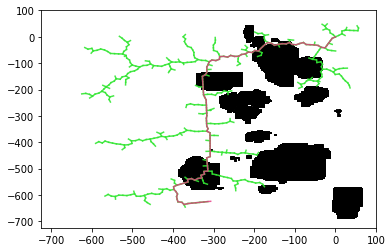

In [ ]:
def draw_map(rrt,path):
    fig = plt.figure()
    ax = plt.axes()
    ax.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])

    rrt.draw_graph(ax)
    rrt.draw_path(ax,path)
    rrt.map.plotobs(ax)
    plt.show()

draw_map(rrt,path)

### # path 좌표 복원
---

In [ ]:
# path 복원
temp = []
for i in path / 10000:
  i[0] += start_grid[0]
  i[1] += start_grid[1]
  temp.append([i[0],i[1]])
final_path = np.array(temp)
final_path

temp = []
for i in range(1,len(final_path)):
  temp.append([final_path[i-1][0],final_path[i-1][1],final_path[i][0],final_path[i][1]])
  
temp

TypeError: ignored